# _k_ nearest neighbours (kNN)

The purpose of this notebook is to understand and implement the kNN algorithm. You are not allowed to use any package that has a complete kNN framework implemented (e.g., scikit-learn).

The kNN algorithm can be used both for classification and  regression. Broadly speaking, it start with calculating the distance of a given point $x$ to all other points in the data set. Then, it finds the _k_ nearest points closest to $x$, and assigns the new point $x$ to the majority class of the _k_ nearest points _(classification)_. So, for example, if two of the _k_=3 closest points to $x$ were red while one is blue, $x$ would be classified as red.

On the other hand in _regression_, we see the labels as continuous variables and assign the label of a data point $x$ as the mean of the labels of its _k_ nearest neighbours. 

In [1]:
import numpy as np
from sklearn.datasets import make_classification, fetch_california_housing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Important things first: You already know that the kNN algorithm is based on computing distances between data points. So, let's start with defining a function that computes such a distance. For simplicity, we will only work with **Euclidean distances** in this notebook, but other distances can be chosen interchangably, of course.

Implement in the following cell the Euclidean distance $d$, defined as
$$
d(\boldsymbol p, \boldsymbol q) = \sqrt{\sum_{i=1}^D{(q_i-p_i)^2}} \, ,
$$
where $\boldsymbol p$ and $\boldsymbol q$ are the two points in our $D$-dimensional Euclidean space.


In [2]:
## EDIT THIS FUNCTION - DONE
def euclidian_distance(p, q):
    return np.sqrt(np.sum((q-p)**2, axis = 1)) ## <-- EDIT THIS LINE - DONE

## 1. Classification

We start with using kNN for classification tasks, and create a dataset with sklearn's [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function and standardise the data.

In [3]:
X_class, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3, random_state=15)

In [4]:
## EDIT THIS FUNCTION - DONE
def standardise(X):
  mu = np.mean(X, 0)
  sigma = np.std(X, 0)
  X_std = (X - mu) / sigma ## <-- EDIT THIS LINE - DONE
  return X_std

In [5]:
X = standardise(X_class)

As with any other supervised machine learning method, we create a train and test set to learn and evaluate our model, respectively.

In [6]:
# stacking data X and labels y into one matrix
data = np.hstack((X, y[:, np.newaxis]))

# shuffling the rows        
np.random.shuffle(data)

# we split train to test as 70:30
split_rate = 0.7
train, test = np.split(data, [int(split_rate*(data.shape[0]))])

X_train = train[:,:-1]
y_train = train[:, -1]

X_test = test[:,:-1]
y_test = test[:, -1]

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [7]:
y_test

array([0, 0, 1, 1, 1, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 2,
       0, 2, 2, 1, 2, 2, 2, 0])

In [8]:
y_train

array([2, 0, 0, 1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 1, 2, 2, 0, 1, 0, 2, 0,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 2, 1, 1, 2, 1, 1, 2, 1, 1, 0,
       1, 2, 0, 1, 0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2, 1, 1, 2, 1, 1,
       0, 1, 1, 0])

We visualise the data set with points in the train set being fully coloured and points in the test being half-transparent.

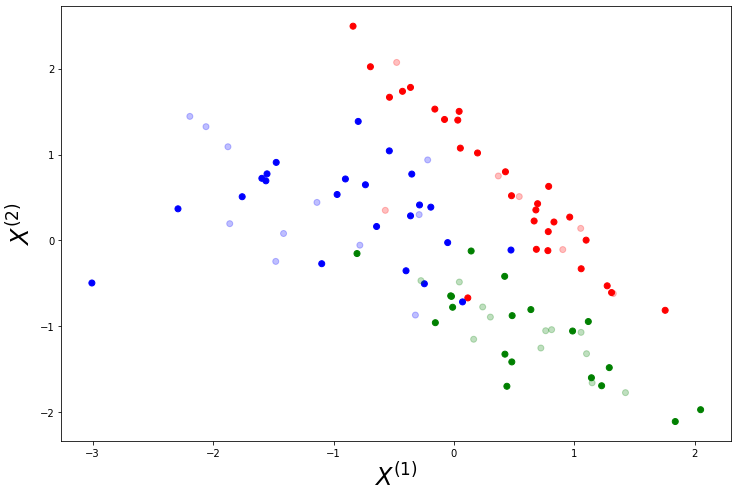

In [9]:
# define colormaps
cm = plt.cm.RdBu
cm_bright = ListedColormap(['blue', 'red', 'green'])

# visual exploration
plt.figure(figsize=(12,8))
plt.xlabel(r'$X^{(1)}$', size=24)
plt.ylabel(r'$X^{(2)}$', size=24)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.25)
plt.show()

We try to find the _k_ nearest neighbours in our train set for every test data point. The majority of labels of the _k_ closest train points determines the label of the test point. 

In [10]:
## EDIT THIS FUNCTION - DONE
def k_neighbours(X_test, k=5, return_distance=False):
  n_neighbours = k
  dist = []
  neigh_ind = []
  
  # compute distance from each point x_text in X_test to all points in X_train 
  # (hint: use python's list comprehension: [... for x_test in X_test])
  point_dist =  [euclidian_distance(x_test, X_train) for x_test in X_test] ## <-- EDIT THIS LINE - DONE

  # determine which k training points are closest to each test point
  for row in point_dist:
      enum_neigh = enumerate(row)
      sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

      ind_list = [tup[0] for tup in sorted_neigh]
      dist_list = [tup[1] for tup in sorted_neigh]

      dist.append(dist_list)
      neigh_ind.append(ind_list)
  
  # return distances together with indices of k nearest neighbouts
  if return_distance:
      return np.array(dist), np.array(neigh_ind)
  
  return np.array(neigh_ind)

Once we know which _k_ neighbours are closest to our test points, we can predict the labels of these test points.

We implement this in a "pythonic" way and call the previous function `k_neighbours` _within_ the next function `predict`.

Our `predict` function determines how any point $x_\text{test}$ in the test set is classified. Here, we only consider the case where each of the *k* neighbours contributes equally to the classification of $x_\text{test}$.

In [11]:
k=5
neighbours = k_neighbours(X_test, k=k)
y_train[neighbours[0]]

array([0, 1, 0, 1, 1])

In [12]:
## EDIT THIS FUNCTION - DONE
def predict(X_test, y_train, k=5):
  # each of the k neighbours contributes equally to the classification of any data point in X_test  
  neighbours = k_neighbours(X_test, k=k)
  # count number of occurences of label with np.bincount and choose the label that has most with np.argmax 
  # (hint: use python's list comprehension: np.array([... for neighbour in neighbours]))
  ## EDIT THIS LINE (below) - DONE
  y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

  return y_pred

To evaluate the algorithm in a more principled way, we need to implement a function that computes the mean accuracy by counting how many of the test points have been classified correctly and dividing this number by the total number of data points in our test set.

Again, we do this is in a pythonic way and call the previous `predict` function _within_ the next function `score`.

In [13]:
## EDIT THIS FUNCTION - DONE
def score(X_test, y_test, y_train, k=5):
  y_pred = predict(X_test, y_train, k=k) ## <-- EDIT THIS LINE - DONE
  return np.float(sum(y_pred==y_test))/ float(len(y_test))

It is quite common to print both the train and test set accuracies.

In [14]:
k = 8
print('Train set mean accuracy:', score(X_train, y_train, y_train, k=k))
print('Test set mean accuracy:', score(X_test, y_test, y_train, k=k))

Train set mean accuracy: 0.9
Test set mean accuracy: 0.9


#### Questions
1. Does the solution above look reasonable?
- Yes
2. Play around with different values for _k_. How does it influence the classification mean accuracy?
- There is an optimal k value, not too high and not too low
3. Compare the train and test set accuracy. Is there a difference? If so, what does the difference tell you?
- Test set accuracy always seems to be lower than train set accuracy. Makes sense as our model in based on the training data not test data, so we expect it to perform better for the training set.
4. Choose different ratios for the split between train and test set, and re-run the entire algorithm. What can you learn from different ratios?
- The accuracy changes a lot depending on the ratios.

## 2. Regression

The kNN algorithm is mostly used for classification, but we can also utilise it for (non-linear) regression. Here, we calculate the label of every point in the test set as the mean of the _k_ nearest neighbours.

We start with defining a train set with sklearn's Californa housing data set. Note that this data set has normally 8 features, but we only extract the first feature, which corresponds to the median income in the district. The label is the median house value in the district.


In [15]:
data = fetch_california_housing(return_X_y=True)
X = data[0][:,0]
y = data[1]

X_std = standardise(X)

As before, we first divide the data into train and test set:

In [16]:
# stacking data X and labels y into one matrix
data_prep = np.asarray([X_std, y]).T

# shuffling the rows        
np.random.shuffle(data_prep)

# we split train to test as 70:30
split_rate = 0.7
train, test = np.split(data_prep, [int(split_rate*(data_prep.shape[0]))])

X_train = train[:,0].reshape(-1,1)
y_train = train[:,1]

X_test = test[:,0].reshape(-1,1)
y_test = test[:,1]

Let's plot it to get a sense how we can proceed. This time, we plot training examples in blue and test examples in red.

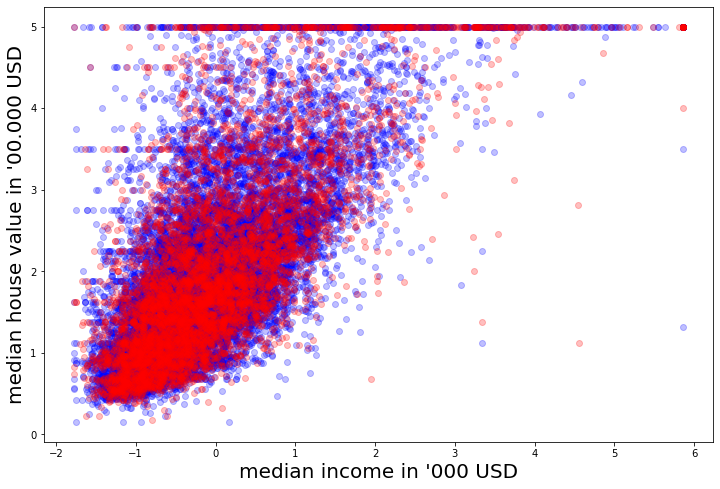

In [17]:
# visual exploration
plt.figure(figsize=(12,8))
plt.xlabel(r"median income in '000 USD", size=20)
plt.ylabel(r"median house value in '00.000 USD", size=20)
plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', alpha=0.25)
plt.show()

As before, we need to define a predicting function which we call `reg_predict`.

In [18]:
## EDIT THIS FUNCTION - DONE
def reg_predict(X_test, y_train, k=20):
  # each of the k neighbours contributes equally to the classification of any data point in X_test  
  neighbours = k_neighbours(X_test, k=k)
  # compute mean over neighbours labels 
  # (hint: use python's list comprehension: np.array([... for neighbour in neighbours]))
  y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours]) ## <-- EDIT THIS LINE - DONE

  return y_pred

In [19]:
# computing predictions... (takes a few minutes due to the high sample size)
k = 20
y_pred = reg_predict(X_test, y_train, k=k)

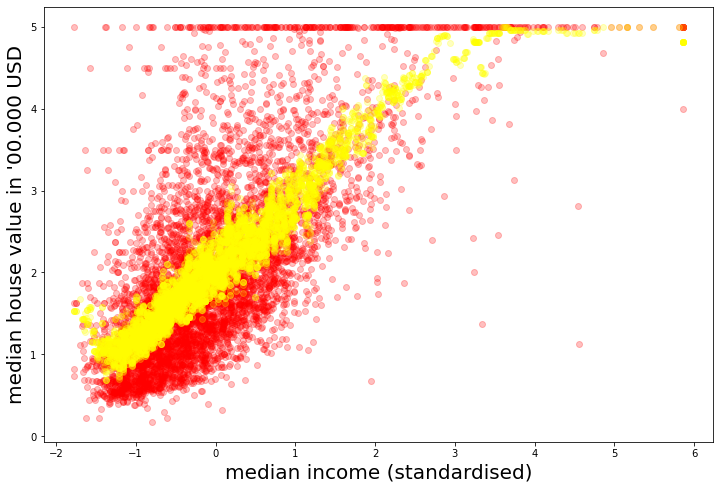

In [20]:
# ... and plotting them
plt.figure(figsize=(12,8))
plt.xlabel(r"median income (standardised)", size=20)
plt.ylabel(r"median house value in '00.000 USD", size=20)
#plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', alpha=0.25)
plt.scatter(X_test, y_pred, c='yellow', alpha=0.25)
plt.show()

To determine how well the prediction was, let us determine the $R^2$ score. The labels of the test set will be called $y$ and the predictions on the test data $\hat{y}$.
$$
R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2} \, ,
$$
where $\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i$.

In [21]:
## EDIT THIS FUNCTION
def r2_score(y_test, y_pred):
  numerator = np.sum((y_test - y_pred)**2) ## <-- EDIT THIS LINE - DONE
  y_avg = np.mean(y_test) ## <-- EDIT THIS LINE - DONE
  denominator = np.sum((y_test - y_avg)**2) ## <-- EDIT THIS LINE - DONE
  return 1 - numerator/denominator

In [22]:
print('Train set mean accuracy:', r2_score(y_train, reg_predict(X_train, y_train, k=k)))


Train set mean accuracy: 0.5121613419871822


In [23]:
print('Test set mean accuracy:', r2_score(y_test, y_pred))

Test set mean accuracy: 0.4751939277801097


#### Questions
1. Does the solution above look reasonable? What does your $R^2$ value tell you?
- Yes, $R^2$ measures the goodness of fit of the model
2. Play around with different values for _k_. How does it influence the regression?
- Affects the width of the range predicted values in the graph
3. Compare the train and test set accuracy. Is there a difference? If so, what does the difference tell you?
- Yes, training set accuracy is higher than test set, as expected (discussed above)
4. Choose different ratios for the split between train and test set, and re-run the entire algorithm. What can you learn from different ratios?
- Accuracy only slightly changes with changing ratios, possibly due to many data points.